****************************************************************
# Machine Learning-based Event Selection
****************************************************************

In this tutorial we present the data preprocessing and handling for the application of machine learning modelf from the Scikit-Learn library. This library is also called the swiss army knife of machine learning. A wide variety of models and preprocessing tools is implemented and carefully maintained.

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, mixture
import cait as ai
# %config InlineBackend.figure_formats = ['svg']  # we need this for a suitable resolution of the plots

In [2]:
path = 'test_data/'
fnames = ['labeled_001']
filepath = ['{}{}.h5'.format(path, f) for f in fnames]

channel = 0

## Data Preprocessing and Training

The data preprocessing, handling and evaluation for sklearn models is done with the EvaluationTools class. 

In [3]:
et = ai.EvaluationTools()

We can add events to the instance from the HDF5 files. Here we have to specify which data is input to the machine learning models. Standard options are the main parameters and the raw time series of the event. However, further below we have a short section bout how to add individual features.

In [4]:
et.add_events_from_file(file=filepath[0],
                    channel=channel,
                    which_data='mainpar',
                    )

We then split the dataset in a training and test set. This is a standard for all machine learning models and should always be done, to optimize the bias-variance tradeoff of our trained models.

In [5]:
et.split_test_train(test_size=0.60)

We can access the training data and labels with the getter function. 

In [6]:
_, _, X_train, _, y_train = et.get_train()

Now we pick a model from the sklearn library, in this case a random forest, i.e. an ensemble of decision trees. Each tree is fit to a subset of the training set and applies repeatedly splits to its data subset, such that it optimizes a given metric in the emerging chunks of the dataset. Typical metrics are entropy for classification tasks and variance for regression. The splits are always applied to the single feature, that has the worst pre-split value in the defined metric.

In [7]:
clf_rf = RandomForestClassifier(criterion='entropy', max_depth=7)

clf_rf.fit(X_train, 
           y_train)

RandomForestClassifier(criterion='entropy', max_depth=7)

We then add its predictions to the instance of EvaluationTools.

In [8]:
et.add_prediction(pred_method='RFC', 
                  pred=clf_rf.predict(et.features), 
                  true_labels=True)

We can repeat this procedure for different models, e.g. a support vector machine. The support vector machines is a linear method that finds a hyperplane in a higher dimensional space with maximal margin to features of different classes in feature space. Often the features are first subject to a non-linear kernel, to achieve non-linear separation in feature space.

In [9]:
clf_svm = svm.SVC()

clf_svm.fit(X_train, 
            y_train)

et.add_prediction(pred_method='SVM', 
                  pred=clf_svm.predict(et.features), 
                  true_labels=True)

Sklearn also has a variety of unsupervised machine learning models, e.g. Gaussian Mixture Models. This is a maximul likelihood fit with several gaussian templates in feature space, typically calcualted with the expectation maximization algorithm.

In [10]:
gmm = mixture.GaussianMixture(n_components=len(np.unique(et.label_nbrs)),
                              covariance_type='full').fit(et.features)

gmm_pred = gmm.predict(et.features)
et.add_prediction(pred_method='GMM', pred=gmm_pred)

Gaussian Mixture Models are the same, but calculate Bayesian estimators for all parameters, including a (in our case non-informative) prior.

In [11]:
bgmm = mixture.BayesianGaussianMixture(n_components=len(np.unique(et.label_nbrs)),
                                           covariance_type='full').fit(et.features)

bgmm_pred = bgmm.predict(et.features)
et.add_prediction(pred_method='BGMM', 
                  pred=bgmm_pred)

## Evaluation

Within the EvaluationTools class, there are several methods to visualize labels and predictions. At first, there is a wrapper around the sklearn class for a t-Stochastic Neighbourhood Embedding. This method constructs a two-dimensional representation of the data points, that retains small euclidean distances between data points (clusters) as good as possible.

Within a Jupyter Notebook, the interactive functionality of Pyplot does not work. If the function is called in the command line, the opened window responds to hovering and displays the event index of the data point. In the future, there will also be the functionality to click on a data point and by that open a window with the time series of the event.

-------------------------------------------------------------------------
Hovering over an event shows you the event number.
When clicking on a single event a window with its timeseries is opened.
Hovering over a a single event and pressing 'm' also opnes the timeseries
of this event and adds the calculated mainparameters to the plot.
-------------------------------------------------------------------------


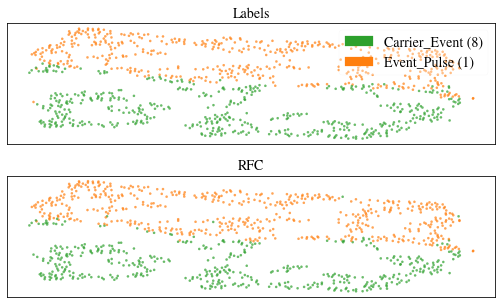

In [12]:
et.plt_pred_with_tsne(pred_methods=['RFC'], what='all', verb=True)

We can do the same thing in a plotly server.

In [13]:
et.plt_pred_with_tsne_plotly(pred_methods=['RFC'], what='all', verb=True)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app 'cait.evaluation_tools' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)


We see that the tSNE achieves a very good separation of carrier and absorber events. We also see, that the RF classifier performs very well in classifying the data, as almost all data points in the two plots match in color.

The second implemented method for visualization is the PCA, that we know already from previous notebooks. Here the PCA might provide a worse visualization than the tSNE, as the data cannot be lienarly projected to a vector subspace without significant information loss.

-------------------------------------------------------------------------
Hovering over an event shows you the event number.
When clicking on a single event a window with its timeseries is opened.
Hovering over a a single event and pressing 'm' also opnes the timeseries
of this event and adds the calculated mainparameters to the plot.
-------------------------------------------------------------------------
Explained Variance:  [0.74676825 0.16831034 0.08379359]
Singular Values:  [77.2926     36.69445089 25.89109298]


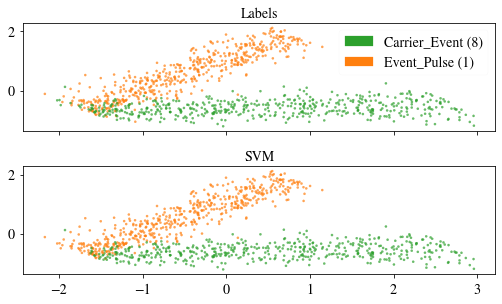

In [14]:
et.plt_pred_with_pca(pred_methods=['SVM'], xy_comp=(1,2), what='all', verb=True)

The EvaluationTools class also contains a plotting rountine for a confusion matrix, to evaluate the per-class distribution of predictions. The random forest classifier obviously does a very well job.

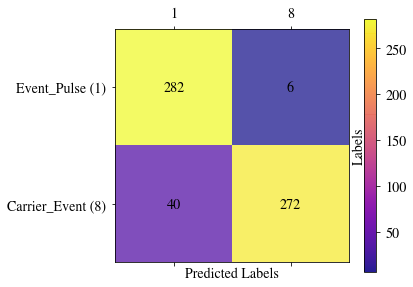

In [15]:
et.confusion_matrix_pred('RFC', what='test', rotation_xticklabels=0, force_xlabelnbr=True, figsize= (6,4))

The Gaussian Mixture Model methods do not map the data distribution to classes, but to clusters. Here we can see, that this unsupervised method does however not identify individual clusters for the different events types in our setting, but chooses to split the absorber events in two clusters. This might be best explained by the fact, that the absorber events take a larger range in feature space than the carrier events and the likelihood for a 2-component gaussian model on our model is higher, if both components cover the distribution of absorber events.

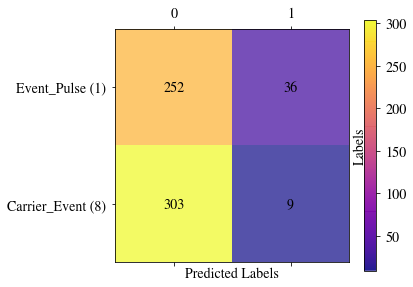

In [16]:
et.confusion_matrix_pred('BGMM', what='test', rotation_xticklabels=0, force_xlabelnbr=True, figsize= (6,4))

## Individual Features

We can use individual features for the events by passing them either dircetly at the filepath setting to the which_data argument, or by overwriting the data at a later point with the set_data method.

.. code:: python

    dh = ai.DataHandler()
    dh.set_filepath(path_h5=path,
                    fname=fnames[0],
                    appendix=False)
                   
    features = dh.get('events', 'pca_projection')[0]
    
    # either hand the data from the beginning right away
    et.add_events_from_file(file=filepath[0],
                        channel=channel,
                        which_data=features,
                        )
                        
    # or overwrite the existing data at a later point
    et.set_data(features)

## Predictions on Real Data

Now we trained our machine learning models on a labeled data set, but ultimately we want to apply them to the whole, unlabeled raw data set. This can be done with a second instance of the evaluation tools. We just have to be careful to use the same scaler for the new data as we used in the training, as the input data would otherwise have a different value range.

In [17]:
et_pred = ai.EvaluationTools()

et_pred.add_events_from_file(file='test_data/test_001.h5',
                        channel=channel,
                        which_data='mainpar',
                        )

# set the scaler from the new instance to the same as from the first instance
et_pred.set_scaler(et.scaler)

predictions = clf_rf.predict(et_pred.features)

et_pred.add_prediction('RFC', predictions, true_labels=True)

In the plot below we see, that the classification works quite well. The t-SNE splits the data in two cluster, but we cannot trust that the cluster exactly correspond to the absorber and carrier events. The split in clusters might be somewhat arbitrary between the low energetic events.

-------------------------------------------------------------------------
Hovering over an event shows you the event number.
When clicking on a single event a window with its timeseries is opened.
Hovering over a a single event and pressing 'm' also opnes the timeseries
of this event and adds the calculated mainparameters to the plot.
-------------------------------------------------------------------------


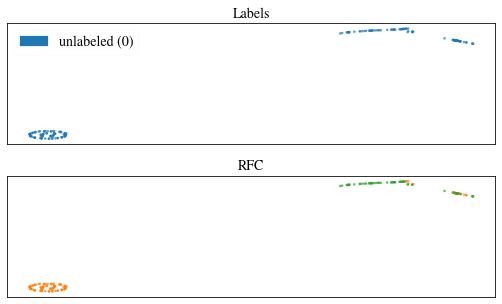

In [18]:
et_pred.plt_pred_with_tsne(pred_methods=['RFC'], what='all', verb=True)

We store the predictions as CSV file in the code above and can include them to a HDF5 file through the DataHandler.

In [19]:
# save the predictions as CSV file
et_pred.save_prediction('RFC',
                       path=path,
                       fname='test_001',
                       channel=channel)

dh = ai.DataHandler(nmbr_channels=2)
dh.set_filepath(path_h5=path,
                fname='test_001',
                appendix=False)

dh.import_predictions(model='RFC',
                   path_predictions=path,
                   only_channel=channel)

Saved Predictions as CSV file.
DataHandler Instance created.
Added RFC Predictions.


If we want to save the model to reuse it at a later point, we can use the ModelHandler class. This is just a wrapper around pickle, to keep the saved models organized. We can hand the classification models for all channels of the detector module and their corresponding scalers as attributes and stored them as a joint object. Also, we can include additional information about the model or training in an info string.

In [22]:
mh = ai.ModelHandler(model_type='RFC')    

mh.add_model(channel=channel,
             model=clf_rf)

mh.add_scaler(scaler=et.scaler,
              channel=channel)

# save
mh.save(path='test_data/rfc.model')

MLModel Instance created.
Added model for channel 0.
Added scaler for channel 0.
Save Model to test_data/rfc.model.


For loading the ModelHandler class, we need to call the pickle.load function from the pickle library.

.. code:: python

    mh = pickle.load(open('test_data/RFC_run01_Test', 'rb+'))

Predictions can also be made directly from the saved model handler, as shown below.

In [24]:
ai.models.mh_predict(h5_path='test_data/test_001.h5',
                   feature_channel=channel,
                   group_name='events',
                   prediction_name = 'RFC',
                   model_handler = None,  # could also hand a model handler here
                   mh_path = 'test_data/rfc.model',
                   which_data = 'mainpar')

Added Predictions: RFC.


Please forward questions and correspondence about this notebook to daniel.bartolot(at)oeaw.ac.at or felix.wagner(at)oeaw.ac.at.